Using 100 science fiction novels from project gutenberg. 

Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

In [741]:
import nltk
import pandas as pd
import numpy as np
import books_files as books 
from urllib import request

In [742]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def text_cleaner(text_data):
    text = re.sub("[^a-zA-Z]",' ',text_data)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [743]:
from io import StringIO

book_text = []
authors = []

for k,v in books.url_dict.items():
    for url in v:
        response = request.urlopen(url)
        raw = response.read().decode('utf8')
        s = StringIO(raw)
        text_lines = []
        for i,line in enumerate(s):
            text_lines.append(line)
            if "START OF THIS PROJECT" in line:
                start_index = (i+1)
            if "END OF THIS PROJECT" in line:
                end_index = i
        book_text.append(' '.join(text_lines[start_index:end_index]))
        authors.append(k)

In [744]:
# 100 different books
print(len(book_text))

100


In [745]:
# 16 different authors
print(len(set(authors)))

16


In [746]:
text_df = pd.DataFrame()
text_df["Text"] = book_text
text_df["Author"] = authors
text_df["Author_ID"] = text_df["Author"].factorize()[0]
text_df.head(3)

,Text,Author,Author_ID
0,"\r\n \r\n \r\n \r\n Produced by Greg Weeks, Ma...",Anderson,0
1,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0
2,\r\n \r\n \r\n \r\n Produced by Sankar Viswana...,Anderson,0


In [747]:
# bag of words
w2v = []
corpus = []
for text in book_text:
    clean_text = text_cleaner(text)
    corpus.append(clean_text)
    clean_text = nltk.word_tokenize(clean_text)
    w2v.append(clean_text)

In [748]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.5,
                             min_df =2,
                             stop_words="english",
                             lowercase=False,
                             use_idf=True,
                             norm=u'l2',
                             smooth_idf=True
                            )

In [749]:
X = tfidf_v.fit_transform(corpus)
y = text_df.iloc[:,2].values

In [750]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [751]:
words = tfidf_v.get_feature_names()

Going to use cosine similarity to generate a measure of similarity between each book in the corpus (tf-idf matrix). We are subtracting the cosine similarity from 1 to get the cosine distance which will be used later on to plot the clusters on a euclidean 2D plane. 

In [752]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X_train)

## KMeans Cluster

### Finding optimal number of clusters

In [753]:
# elbow method
from sklearn.cluster import KMeans
wcss = []
n_clusters = range(1,10)
for i in n_clusters:
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

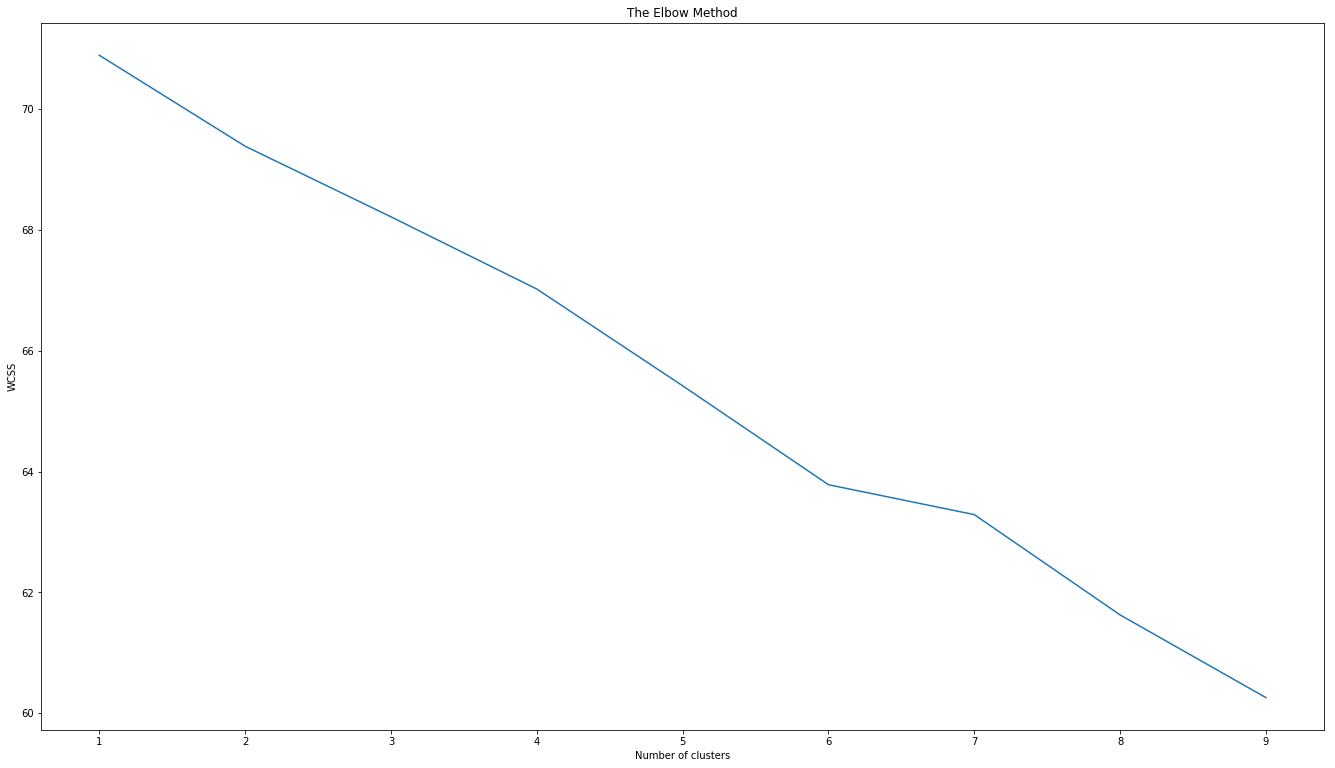

In [754]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(n_clusters,wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(n_clusters)
plt.show()

In [755]:
# 6 clusters seems optimal
num_clusters = 6
km = KMeans(n_clusters=num_clusters,random_state=42)

In [756]:
km.fit(X_train)
clusters = km.labels_.tolist()

In [757]:
books = {"author":y_train,"book_text":X_train,"cluster":clusters}
frame = pd.DataFrame(books,index=[clusters],columns=["author","book_text","cluster"])

In [758]:
author_id = {}
for author in list(text_df["Author_ID"]):
    if author not in author_id:
        author_id[author] = text_df.loc[text_df["Author_ID"]==author,"Author"].iloc[0]
author_id

{0: 'Anderson',
 1: 'Ashwell',
 2: 'Beck',
 3: 'Breuer',
 4: 'Buckner',
 5: 'Budrys',
 6: 'Clifton',
 7: 'Cogan',
 8: 'Del Rey',
 9: 'Fyfe',
 10: 'Garrett',
 11: 'Leiber',
 12: 'Reynolds',
 13: 'Wells',
 14: 'Williams',
 15: 'Zagat'}

In [759]:
frame["cluster"].value_counts()

3    45
1     9
0     9
2     6
4     4
5     2
Name: cluster, dtype: int64

## Getting top 10 words and authors per cluster

In [760]:
from __future__ import print_function

print("Authors per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
cluster_names = {}

for i in range(num_clusters):
    cluster_names[i] = ""
    print("Cluster %d:"%i)
    print("Top 10 words:")
    for ind in order_centroids[i,:10]:
        cluster_names[i] += ("{} ".format(str(words[ind])))
        print("%s"%words[ind])
    cluster_names[i] = ','.join(cluster_names[i].split())
    print()
    print("Cluster %d authors:" % i, end='')
    for author in frame.loc[i]['author'].values.tolist():
        print(' %s,' % author_id[author], end='')
    print() #add whitespace
    print() #add whitespace

Authors per cluster:

Cluster 0:
Top 10 words:
henry
kennedy
guesser
zen
senator
aunt
robert
lieutenant
robot
kitty

Cluster 0 authors: Anderson, Clifton, Clifton, Del Rey, Garrett, Fyfe, Clifton, Williams, Clifton,

Cluster 1:
Top 10 words:
martian
mar
sand
jorgensen
ro
loaf
desert
meadow
bread
pete

Cluster 1 authors: Williams, Budrys, Anderson, Wells, Fyfe, Leiber, Williams, Leiber, Anderson,

Cluster 2:
Top 10 words:
joe
fisher
willard
smith
thinker
taranto
brett
calculator
max
ivar

Cluster 2 authors: Fyfe, Reynolds, Fyfe, Reynolds, Reynolds, Leiber,

Cluster 3:
Top 10 words:
dane
mead
moon
blade
dr
gordon
sea
colonel
porter
thompson

Cluster 3 authors: Budrys, Williams, Ashwell, Breuer, Wells, Cogan, Anderson, Leiber, Leiber, Del Rey, Budrys, Williams, Wells, Clifton, Leiber, Budrys, Budrys, Del Rey, Anderson, Anderson, Leiber, Zagat, Garrett, Garrett, Leiber, Fyfe, Leiber, Williams, Garrett, Williams, Garrett, Del Rey, Garrett, Wells, Del Rey, Cogan, Clifton, Anderson, Wells, Re

## K-Means Clusters visual (dimension reduction)

In [761]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

X_norm = normalize(dist)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

In [762]:
variance_explained = pca.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: ",total_variance*100)

Percent variance captured by all components:  11.711361824765868


In [763]:
xs,ys = X_pca[:,0],X_pca[:,1]

In [764]:
#set up colors per clusters using a dict
cluster_colors = {0: '#ffe059', 1: '#9cff07', 2: '#ff0707', 3: '#07ffc1', 4: '#a407ff',5: '#ff07bc'}

#cluster_names = {0: 'joe, kenzie, guy, instructor, chessman, chief, watson, brett, buckner, baron', 
                 #1: 'johnny, mead, kennedy, captain, geoffrey, dane, commodore, ron, aunt, wilkins', 
                 #2: 'nipe, stanton, mannheim, bart, yoritomo, martin, colonel, farnsworth, rat, wang', 
                 #3: 'colonel, guesser, zen, porter, senator, gibson, bending, charlie, parker, stoker', 
                 #4: 'gordon, thompson, ross, muller, mar, doctor, henry, fisher, doc, reactor',
                 #5: 'martian, robot, robert, kitty, presently, miller, animal, redwood, beast, blackie'}

In [765]:
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, author=[author_id[i] for i in y_train])) 

groups = df.groupby('label')

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on'

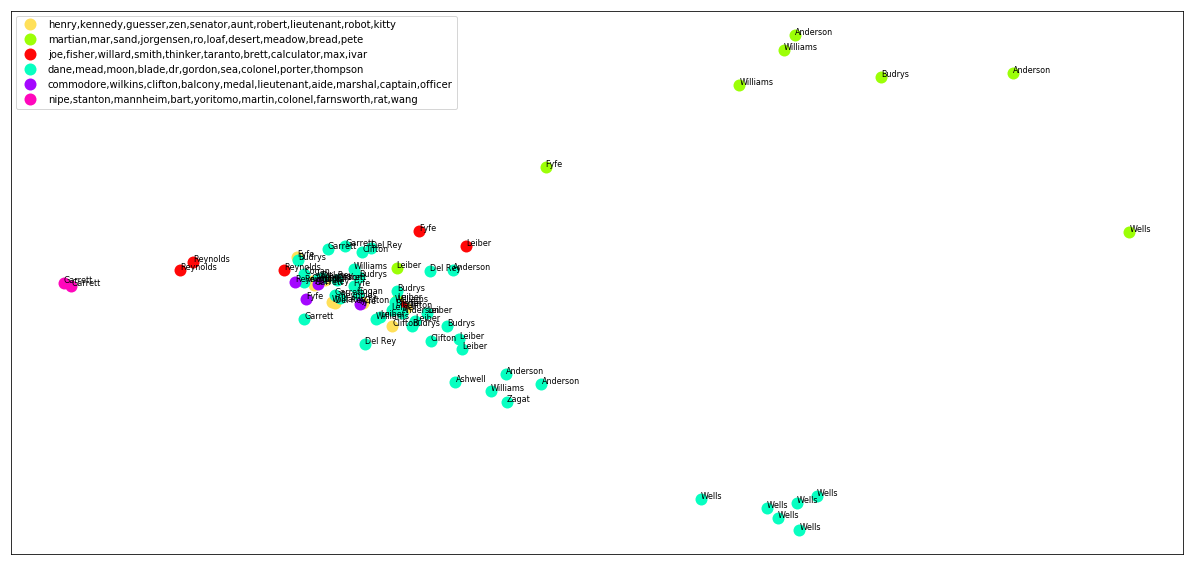

In [766]:
fig, ax = plt.subplots(figsize=(21, 10))

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelbottom='False')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='False',      # ticks along the bottom edge are off
        top='False',         # ticks along the top edge are off
        labelleft='False')

ax.legend(numpoints=1)  #show legend with only 1 point

for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['author'], size=8)  

plt.show()

## Hierarchical Cluster visual

/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/glenn/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


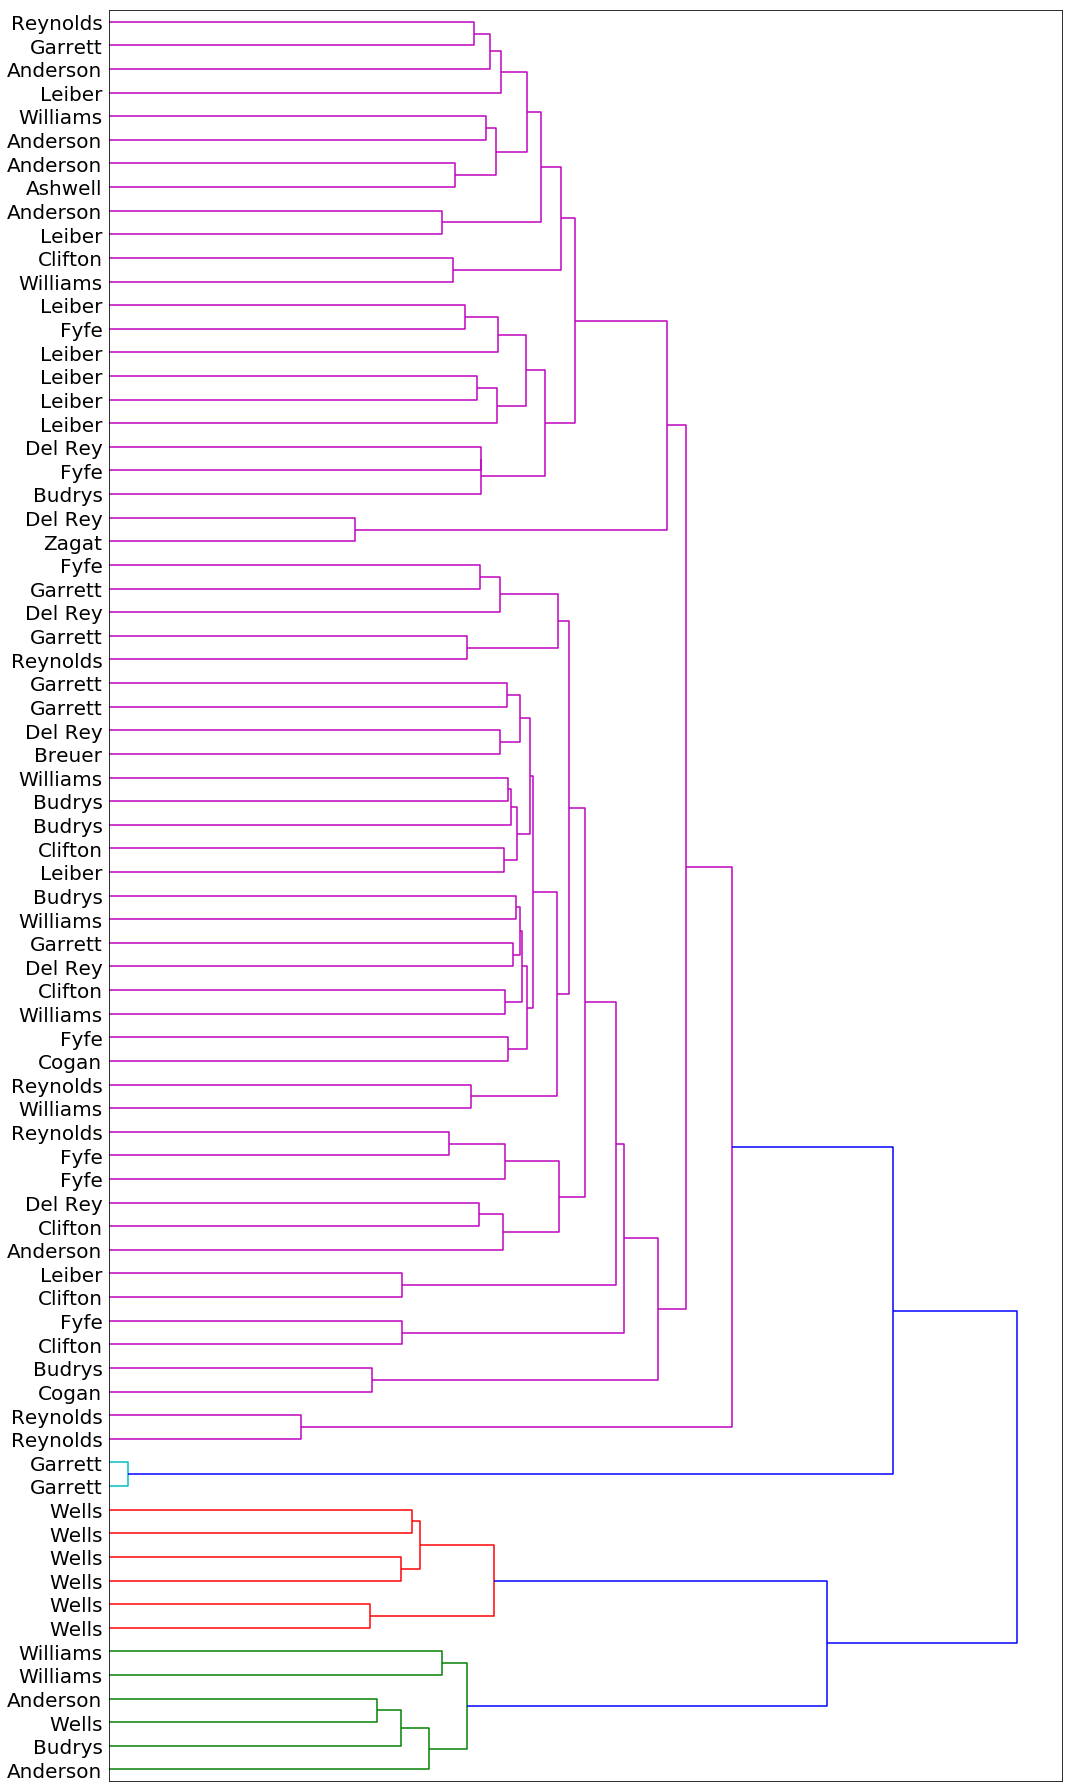

In [767]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 25)) # set size

ax = dendrogram(linkage_matrix, orientation="right", labels=[author_id[i] for i in y_train]);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='False',      # ticks along the bottom edge are off
    top='False',         # ticks along the top edge are off
    labelbottom='False')
plt.tick_params(labelsize=20)
plt.tight_layout() #show plot with tight layout

## Classifying book texts by author (Supervised Learning Application)

We will attempt to use supervised and unsupervised learning techniques to identify the authors by their respective book texts. 

In [768]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [769]:
# use PCA to generate features (features should be less than 100, only have 100 different books)
#X_norm_features = normalize(X.toarray())
pca = PCA(0.95)
X_features = pca.fit_transform(X.toarray())

In [770]:
ypred_km = km.predict(X)

In [771]:
features_rough = np.concatenate((X_features,ypred_km[:,None]),axis=1)

In [772]:
features_df = pd.DataFrame(features_rough)

In [773]:
features_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.196060,-0.079480,-0.027397,0.010838,-0.080932,-0.074442,0.029158,-0.085913,0.143109,0.023722,...,-0.012765,0.056190,-0.044227,-0.090414,-0.004748,0.024528,0.042712,-0.005061,-0.042471,3.0
1,0.304537,0.545216,0.148707,0.119751,0.015757,-0.003862,0.066842,-0.022513,0.050071,-0.007848,...,-0.050962,-0.068088,-0.042984,0.022800,0.061977,0.074737,-0.040843,0.079056,0.054653,1.0
2,-0.013438,-0.014035,-0.016761,-0.055212,-0.146516,-0.119204,-0.051486,-0.032582,-0.012442,-0.014211,...,0.170569,0.031174,-0.040929,-0.042969,0.027789,-0.053824,-0.010709,0.012152,-0.004835,3.0


In [774]:
dummy = pd.get_dummies(features_df[90])
dummy.head(3)

,0.0,1.0,2.0,3.0,4.0,5.0
0,0,0,0,1,0,0
1,0,1,0,0,0,0
2,0,0,0,1,0,0


In [775]:
features_df = pd.concat([features_df,dummy],axis=1)

In [776]:
features_df = features_df.drop([90.0,5.0],axis=1)

In [777]:
features_df.head(3)

,0.0,1.0,2.0,3.0,4.0,6.0,7.0,8.0,9.0,10.0,...,85.0,86.0,87.0,88.0,89.0,0.0,1.0,2.0,3.0,4.0
0,0.196060,-0.079480,-0.027397,0.010838,-0.080932,0.029158,-0.085913,0.143109,0.023722,0.113971,...,-0.004748,0.024528,0.042712,-0.005061,-0.042471,0,0,0,1,0
1,0.304537,0.545216,0.148707,0.119751,0.015757,0.066842,-0.022513,0.050071,-0.007848,0.014701,...,0.061977,0.074737,-0.040843,0.079056,0.054653,0,1,0,0,0
2,-0.013438,-0.014035,-0.016761,-0.055212,-0.146516,-0.051486,-0.032582,-0.012442,-0.014211,-0.038055,...,0.027789,-0.053824,-0.010709,0.012152,-0.004835,0,0,0,1,0


In [778]:
X = features_df.iloc[:,:-1].values

In [779]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [780]:
models=[
    LogisticRegression(random_state=42),
    RandomForestClassifier(n_estimators=300,max_depth=3,random_state=42),
    SVC(),
    #MultinomialNB(),
    XGBClassifier()
]

In [781]:
CV = 6
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model,X,y,scoring="accuracy",cv=CV)
    
    for fold_idx,accuracy in enumerate(accuracies):
        entries.append((model_name,fold_idx,accuracy))

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=6.
  % (min_groups, self.n_splits)), Warning)
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 membe

In [782]:
cv_df = pd.DataFrame(entries,columns=["model_name","fold_idx","accuracy"])

In [783]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.275267
RandomForestClassifier    0.343269
SVC                       0.176335
XGBClassifier             0.331446
Name: accuracy, dtype: float64

### Evaluating Classification Model Performance (XGBClassifier)

In [784]:
xgc = XGBClassifier()

xgc.fit(X_train,y_train)
ypred_xgc = xgc.predict(X_test)

/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


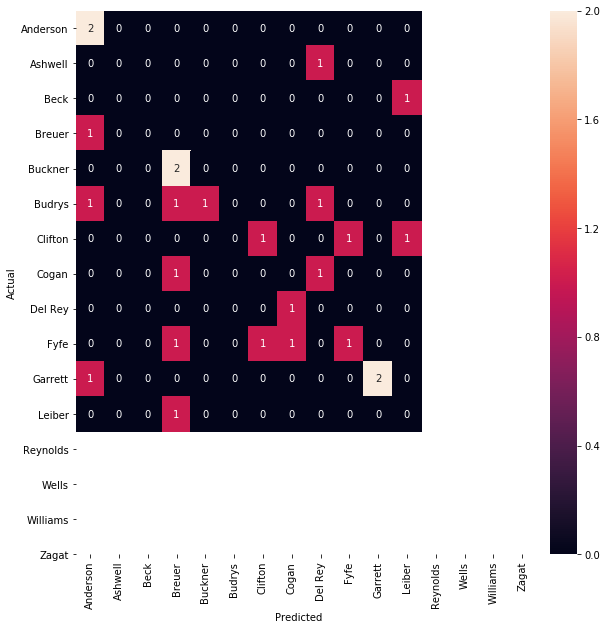

In [785]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test,ypred_xgc)

fig,ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat,annot=True,fmt='d',xticklabels=[v for k,v in author_id.items()],yticklabels=[v for k,v in author_id.items()])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [786]:
# classification report for each class (XGC)
from sklearn import metrics

print(metrics.classification_report(y_test,ypred_xgc,target_names=[v for k,v in author_id.items()]))

             precision    recall  f1-score   support

   Anderson       0.40      1.00      0.57         2
    Ashwell       0.00      0.00      0.00         1
       Beck       0.00      0.00      0.00         1
     Breuer       0.00      0.00      0.00         1
    Buckner       0.00      0.00      0.00         2
     Budrys       0.00      0.00      0.00         4
    Clifton       0.50      0.33      0.40         3
      Cogan       0.00      0.00      0.00         2
    Del Rey       0.00      0.00      0.00         1
       Fyfe       0.50      0.25      0.33         4
    Garrett       1.00      0.67      0.80         3
     Leiber       0.00      0.00      0.00         1

avg / total       0.29      0.24      0.24        25



/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 12, does not match size of target_names, 16
  .format(len(labels), len(target_names))
/home/glenn/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Next steps:

1. Get a benchmark of all supervised learning models (fitting and comparing accuracy scores)

2. Evaluate the best model (most accurate, best score) using confusion matrix

3. Explore sklearn's classification_report module

4. Use word2vec for feature engineering, visualize & interpret clusters made by word2vec (TSNE & Affinity Propagation)

5. Extra: Apply supervised learning models to word2vec features